#### Diagnosis of the behaviour of delSM to P-E-Q regression relationship to understand the underestimation of drought breaking probabilities estimated by the method

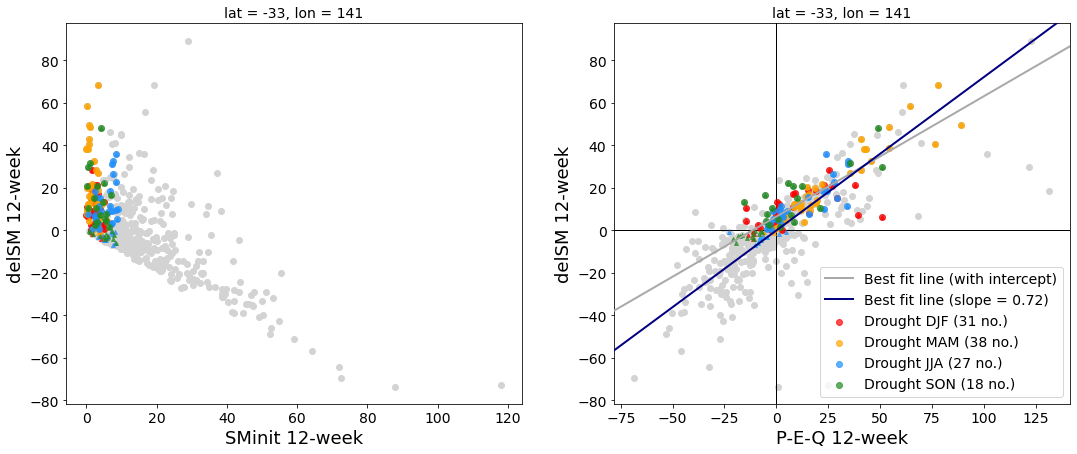

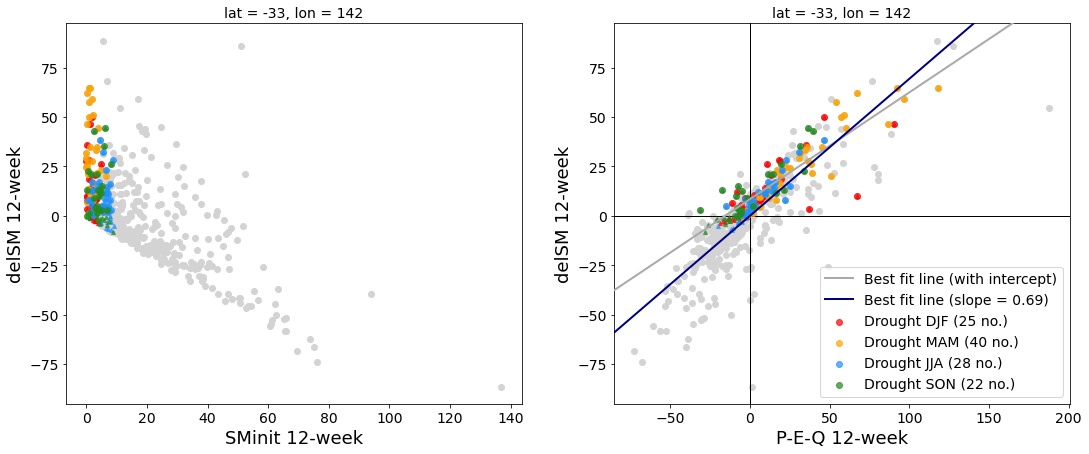

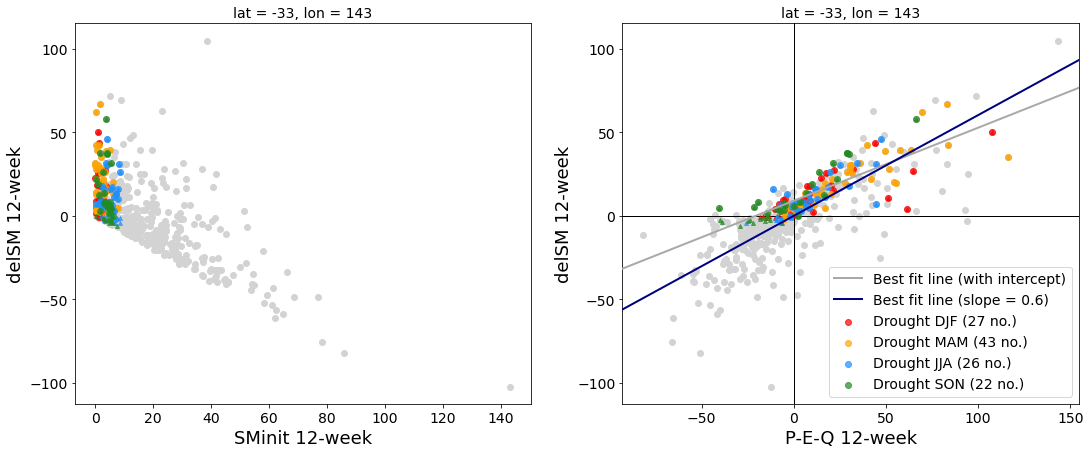

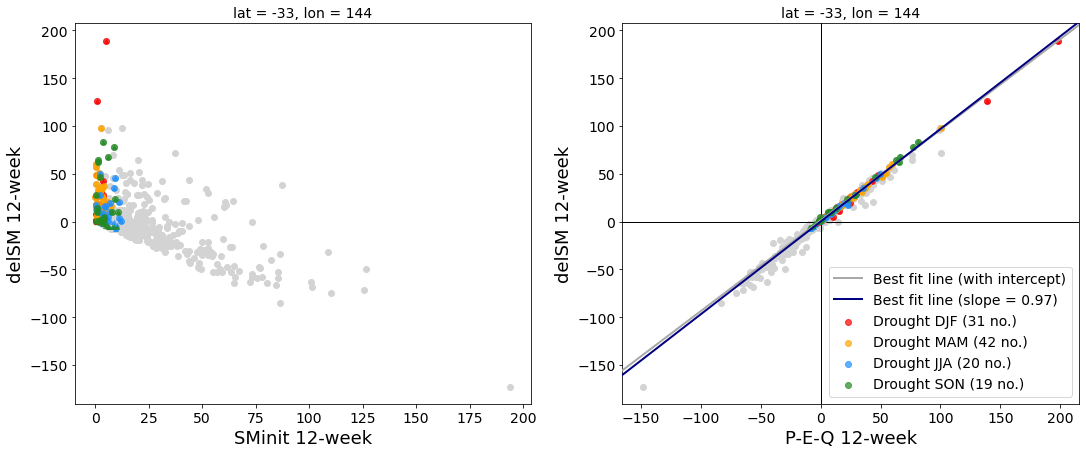

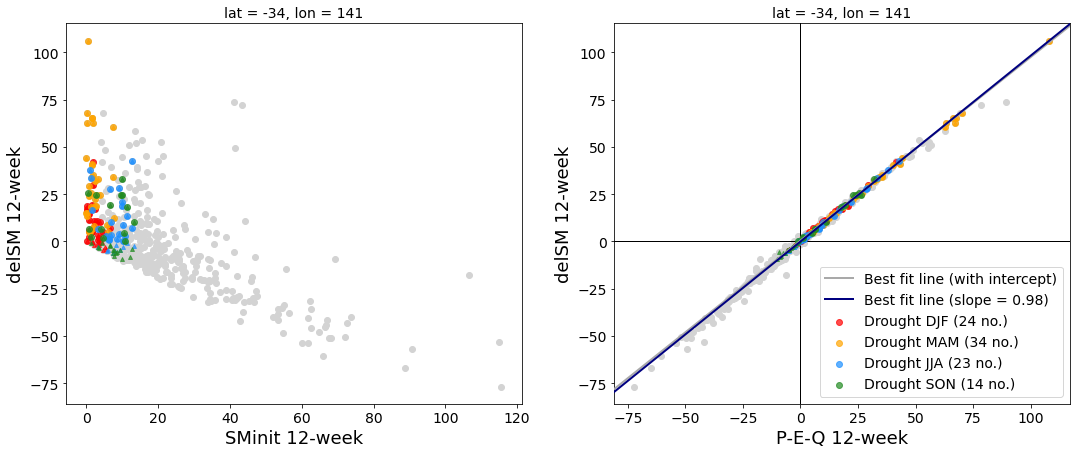

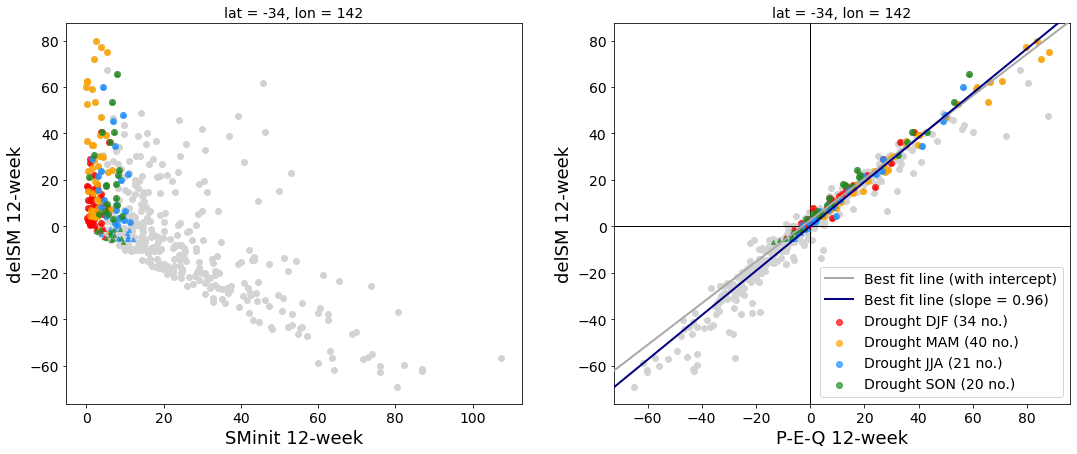

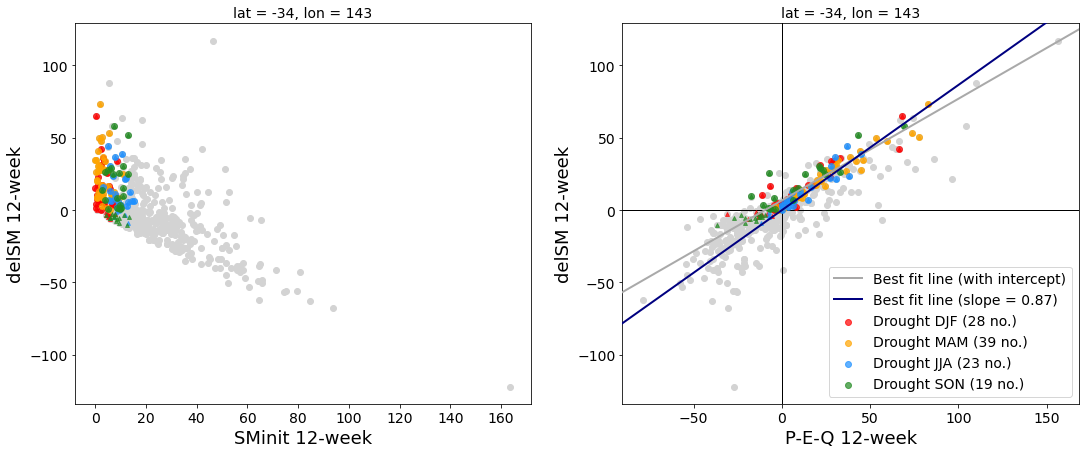

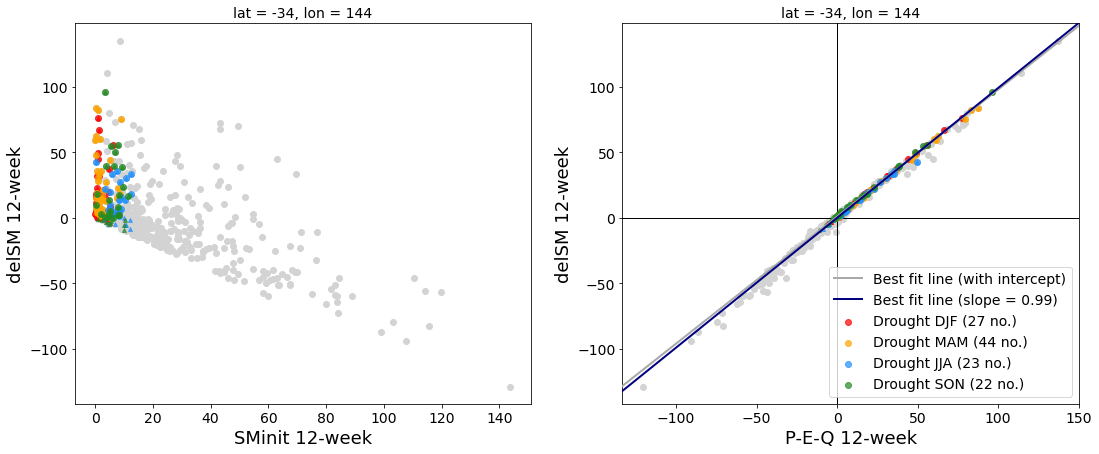

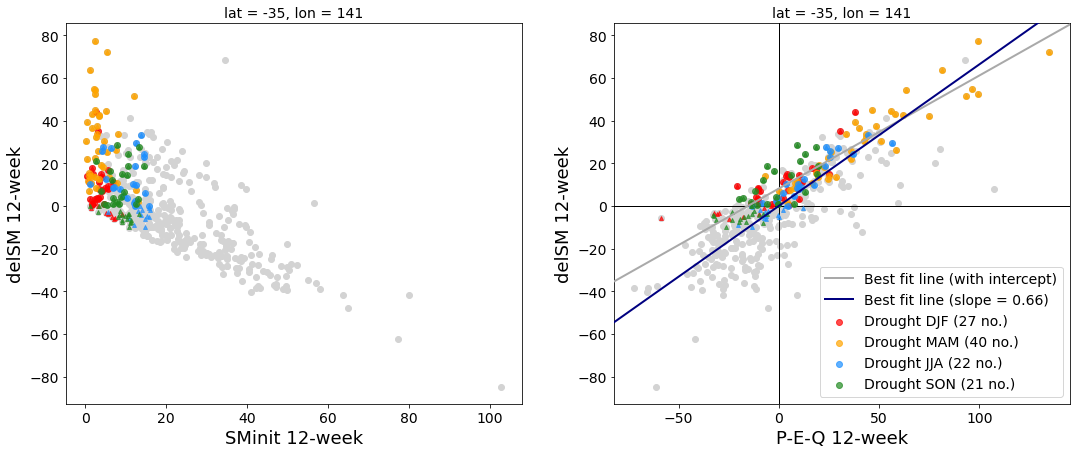

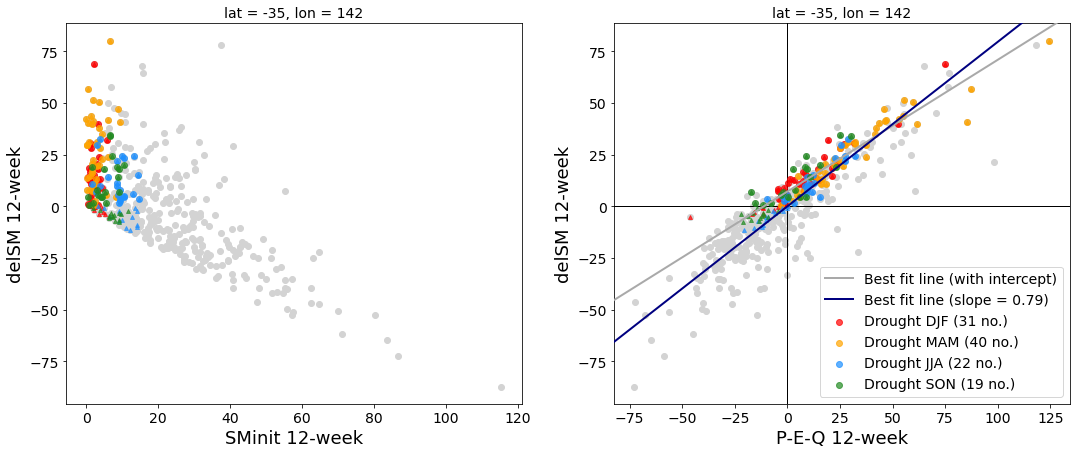

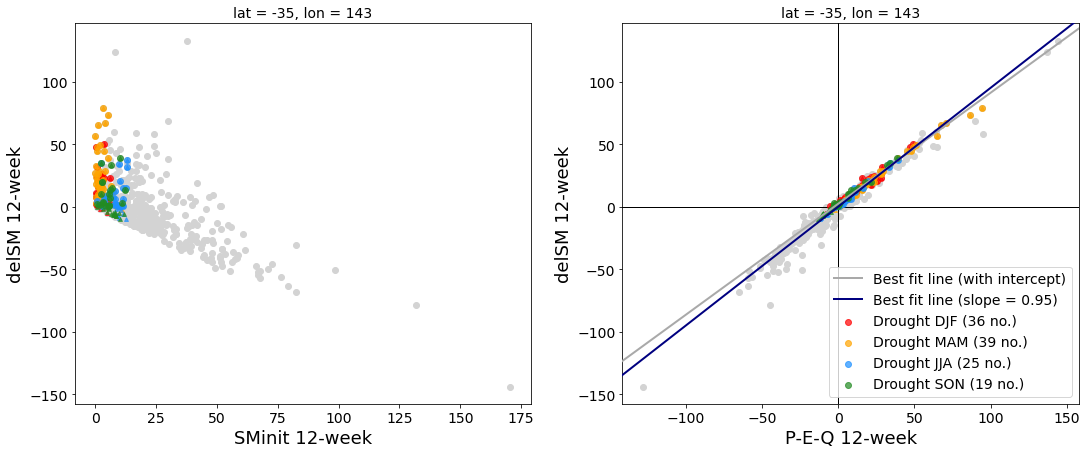

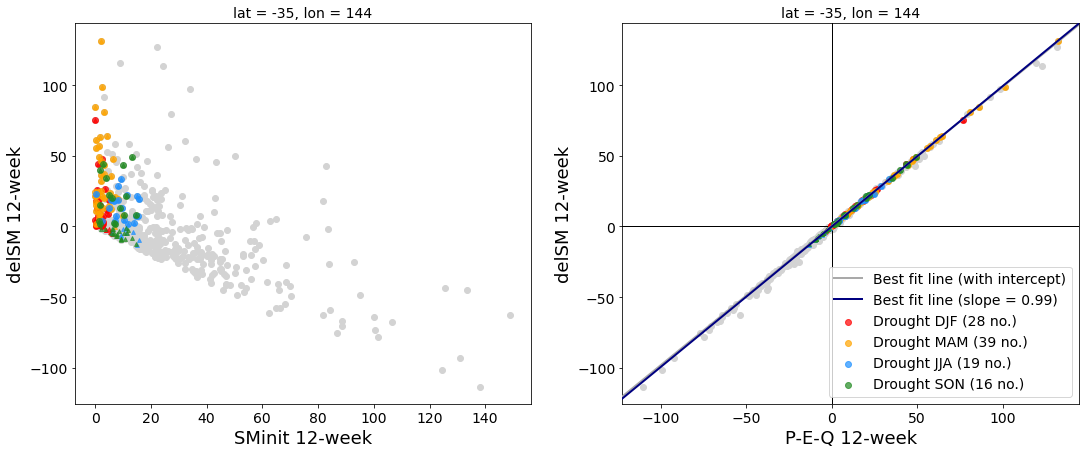

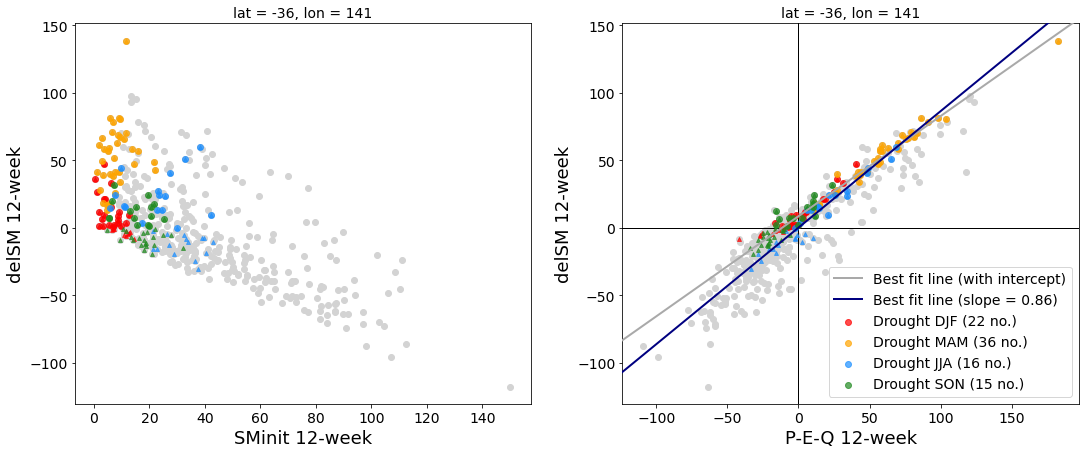

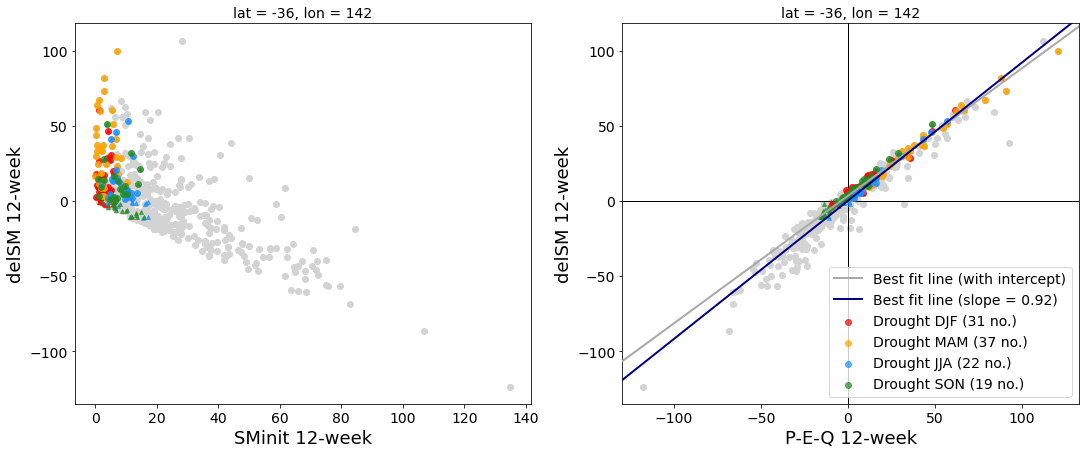

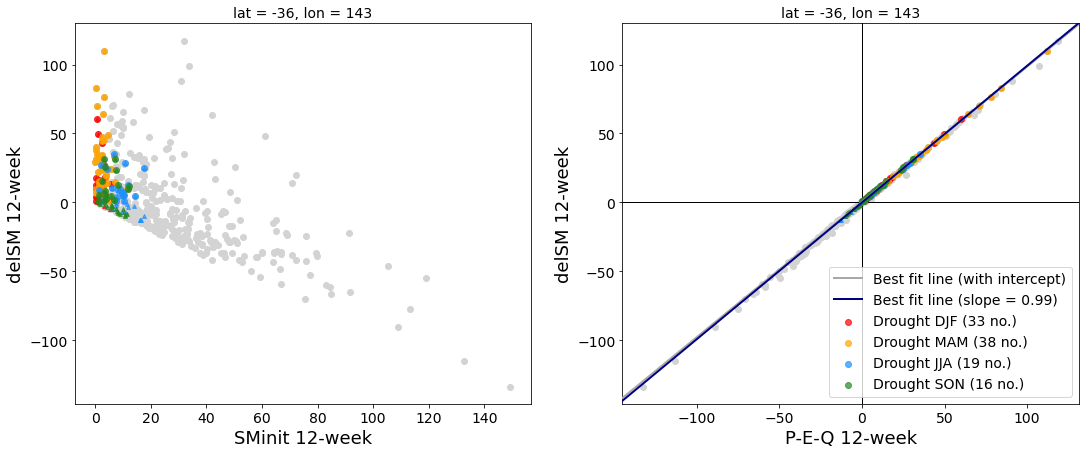

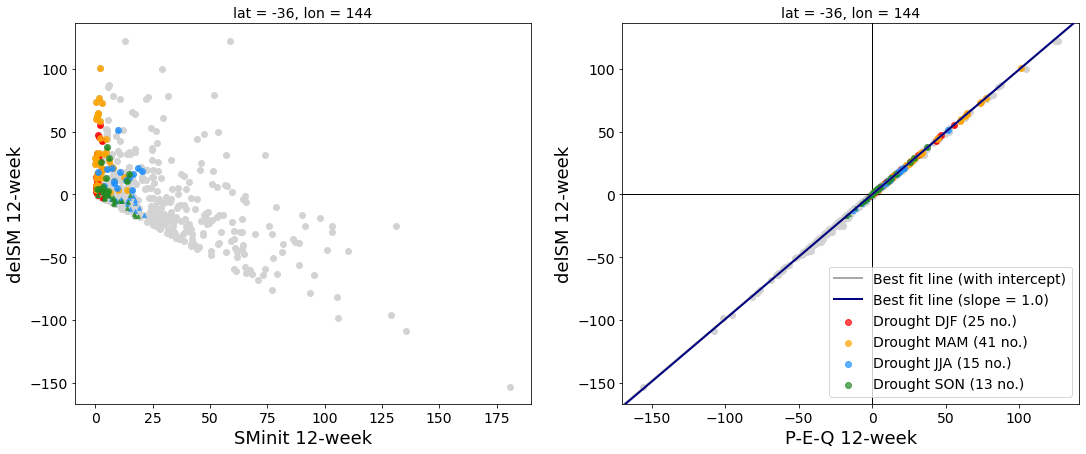

In [43]:
# Does the above relationship change with season?
# Is the relationship stronger in cases where the initial soil moisture is classified as serious or severe deficiency (i.e., drought?). 
# The would be below the 10 percentile thershold of long-term sm
# Can I use a higher threshold of 30th percentile to look at this relationship?
# I need to exclude data points with a negative soil moisture change as the relationship is only about positive changes in SM
#-------------------------------------------------------------------------
# Note: I changed the code to use the 30th perc. Change back if needed
#-------------------------------------------------------------------------

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

outdir = 'figures/SM_PmEQ_diagnosis/'

########## Add more when calculated #########
multiweek = np.array([2, 6, 12])
#############################################

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'
fname_PmE = 'PminusE_*_SEA_*.nc'

lat_pt_list = [-33, -33, -33, -33, 
               -34, -34, -34, -34,
               -35, -35, -35, -35,
               -36, -36, -36, -36]
               #-37
lon_pt_list = [141, 142, 143, 144,
               141, 142, 143, 144,
               141, 142, 143, 144,
               141, 142, 143, 144]  
               #142
sm_thresh_perc = 0.3     # this is the thershold percentile to identify dry soil moisture conditions

def abline(slope, intercept, axes, linestyle = (0,(5,5)), color="black", linewidth=1, label="", zorder=1):
    """Plot a line from slope and intercept"""
    axes_xlim = axes.get_xlim()
    axes_ylim = axes.get_ylim()
    x_vals = np.append(np.append(np.array(axes_xlim[0]-500), np.array(axes.get_xlim())), np.array(axes_xlim[1]+500))
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, linestyle=linestyle, color=color, linewidth=linewidth, label=label, zorder=zorder)
    axes.set(xlim = axes_xlim, ylim = axes_ylim)
    
seas_names = ['DJF', 'MAM', 'JJA', 'SON']
seas_col = {'DJF':'red', 'MAM':'orange', 'JJA':'dodgerblue', 'SON':'forestgreen'}

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for iW in [multiweek[2]]:
    for ipt in range(len(lat_pt_list)):
        lat_pt = lat_pt_list[ipt]
        lon_pt = lon_pt_list[ipt]    
        figname = 'lat' + str(lat_pt) + '_lon' + str(lon_pt) + '_SM_vs_PmEQ_week' + str(iW) + '_droughtPts_bySeason_30pThresh.png'

        data_dir_PmEQ = '/g/data/w97/ad9701/p_prob_analysis/temp_files/PminusEQ_week'+str(iW)+'/'
        ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':400, 'lon':400}) #, combine='nested', concat_dim='time', chunks={'lat':1,'lon':1})

        data_dir_sm = '/g/data/w97/ad9701/p_prob_analysis/temp_files/sm_week'+str(iW)+'/'
        ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':400, 'lon':400})
        ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':400, 'lon':400}) 

        da_PmEQ_pt_temp = ds_PmEQ['PminusEQ'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").load()#.groupby('time.season')
        da_sm_init_pt_temp = ds_sm_init['sm'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").load()#.groupby('time.season')
        da_sm_diff_pt_temp = ds_sm_diff['sm_diff'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").load()#.groupby('time.season')    

        # get the fitted parameters between del SM and P-E-Q
        ds_lm = xr.open_dataset(data_dir_sm + 'sm_PmEQ_lm_results.nc')
        ds_lm_noI = xr.open_dataset(data_dir_sm + 'sm_PmEQ_lm_noIntercept_results.nc')

        ds_lm_slope = ds_lm['lm_params'].sel(lat = lat_pt, lon = lon_pt, parameter = "PmEQ").values
        ds_lm_intercept = ds_lm['lm_params'].sel(lat = lat_pt, lon = lon_pt, parameter = "Intercept").values
        ds_lm_noI_slope = ds_lm_noI['lm_params'].sel(lat = lat_pt, lon = lon_pt, parameter = "PmEQ").values

        da_sm_init_pt = da_sm_init_pt_temp.groupby('time.season')
        da_sm_diff_pt = da_sm_diff_pt_temp.groupby('time.season')

        # reassigning the time dimension of PmE and PmEQ to match sm exactly
        da_PmEQ_pt = da_PmEQ_pt_temp.assign_coords(time = da_sm_init_pt_temp.time).groupby('time.season')

        ds_sm_perc = xr.open_dataset('/g/data/w97/ad9701/p_prob_analysis/temp_files/sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
        da_sm_thresh_pt = ds_sm_perc['sm'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").sel(quantile = sm_thresh_perc).load()

        # day of year is not properly assigned in the dataset of percentiles; reassigning
        dayofyear = np.arange(366)+1
        da_sm_thresh_pt = da_sm_thresh_pt.assign_coords(dayofyear = dayofyear)

        fig, axs = plt.subplots(1,2, figsize=(18, 7))
        axs = axs.flatten()

        colorSel = "lightgrey"
        colourDrght = "red"

        titleText = 'lat = ' + str(lat_pt) + ', lon = ' + str(lon_pt)
        xlab_list = ['SMinit ' + str(iW) + '-week',\
                     #'SMinit ' + str(iW) + '-week',\
                     'P-E-Q ' + str(iW) + '-week']
        ylab_list = ['delSM ' + str(iW) + '-week',\
                     #'P-E-Q ' + str(iW) + '-week',\
                     'delSM ' + str(iW) + '-week']

        for iSeas in seas_names:
            # get the corresponding 10th perc thershold for each day in the init sm dataset
            da_sm_init_thresh_pt = da_sm_thresh_pt.sel(dayofyear = da_sm_init_pt[iSeas]['time.dayofyear'])

            # Is the relationship during drought conditions very different from the non-drought initial conditions?
            # Also exclude cases where the delta change in soil moisture is negative
            droughtInd_1 = [x & y for (x, y) in zip((da_sm_init_pt[iSeas]<=da_sm_init_thresh_pt).values, (da_sm_diff_pt[iSeas]>0).values)]
            droughtInd_2 = (da_sm_init_pt[iSeas]<=da_sm_init_thresh_pt).values
            nPts = sum(droughtInd_1)

            data_x = [da_sm_init_pt[iSeas], #da_sm_init_pt[iSeas], 
                      da_PmEQ_pt[iSeas]]
            data_y = [da_sm_diff_pt[iSeas], #da_PmEQ_pt[iSeas], 
                      da_sm_diff_pt[iSeas]]

            for iX in np.arange(2):
                axs[iX].scatter(data_x[iX], data_y[iX], color = colorSel, marker = "o")
                axs[iX].scatter(data_x[iX][droughtInd_1], data_y[iX][droughtInd_1], color = seas_col[iSeas], label = "Drought "+iSeas+" ("+str(nPts)+" no.)", marker = "o", zorder=10, alpha =0.7) #, capsize = 5)
                axs[iX].scatter(data_x[iX][droughtInd_2], data_y[iX][droughtInd_2], color = seas_col[iSeas], marker = "^", zorder=10, alpha =0.7, s = 15)

        for iX in np.arange(2):
            axs[iX].set(title = titleText, xlabel = xlab_list[iX], ylabel = ylab_list[iX])

        # for iX in np.arange(2):
        #     legend = axs[iX].legend(loc='upper right')

        for iX in [1]:
            axs[iX].axhline(0, color = "black", linewidth=1)
            axs[iX].axvline(0, color = "black", linewidth=1)
            abline(ds_lm_slope, ds_lm_intercept, axs[iX], linewidth=2, label = "Best fit line (with intercept)", color = "darkgray", linestyle = "solid", zorder=11)
            abline(ds_lm_noI_slope, 0, axs[iX], linewidth=2, label = "Best fit line (slope = " + str(ds_lm_noI_slope.round(2)) + ")", color = "navy", linestyle = "solid", zorder=11)
            legend = axs[iX].legend(loc='lower right')
        plt.savefig(outdir+figname)

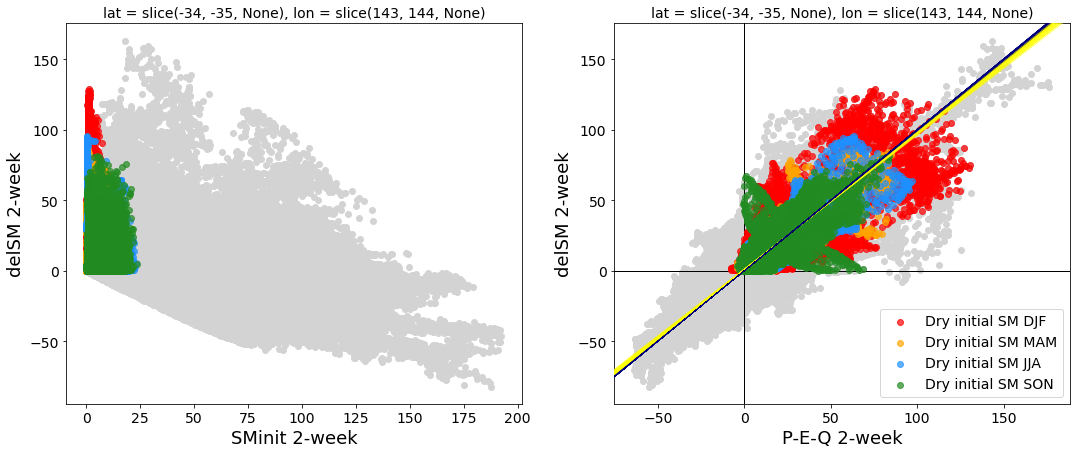

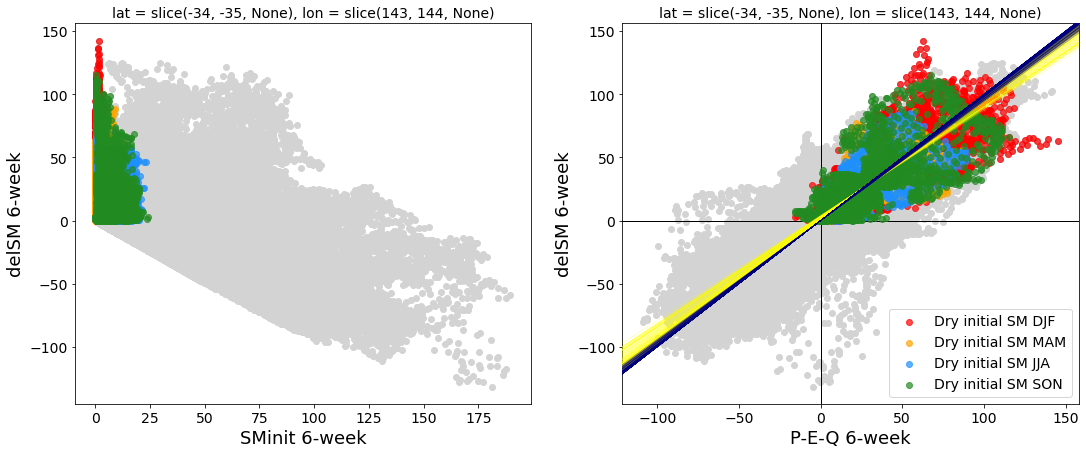

In [1]:
# plot data from multiple grids together

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

outdir = 'figures/SM_PmEQ_diagnosis/'

########## Add more when calculated #########
multiweek = np.array([2, 6, 12])
#############################################

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'
fname_PmE = 'PminusE_*_SEA_*.nc'

lat_pt_list = [slice(-34, -35)]
# lat_pt_list = [slice(-33, -34), slice(-33, -34), slice(-33, -34), slice(-33, -34), slice(-33, -34),
#                slice(-34, -35), slice(-34, -35), slice(-34, -35), slice(-34, -35), slice(-34, -35),
#               slice(-35, -36), slice(-35, -36), slice(-35, -36), slice(-35, -36), slice(-35, -36)]
# lat_pt_rev_list = [slice(-34, -33), slice(-34, -33), slice(-34, -33), slice(-34, -33), slice(-34, -33),
#                   slice(-35, -34), slice(-35, -34), slice(-35, -34), slice(-35, -34), slice(-35, -34),
#                   slice(-36, -35), slice(-36, -35), slice(-36, -35), slice(-36, -35), slice(-36, -35)]
lat_pt_rev_list = [slice(-35, -34)]
# [-33, -33, -33, -33, 
#                -34, -34, -34, -34,
#                -35, -35, -35, -35,
#                -36, -36, -36, -36]
               #-37
# lon_pt_list = [slice(141, 142), slice(142, 143), slice(143, 144), slice(144, 145), slice(145, 146),
#                slice(141, 142), slice(142, 143), slice(143, 144), slice(144, 145), slice(145, 146),
#                slice(141, 142), slice(142, 143), slice(143, 144), slice(144, 145), slice(145, 146)]
lon_pt_list = [slice(143, 144)]
# [141, 142, 143, 144,
#                141, 142, 143, 144,
#                141, 142, 143, 144,
#                141, 142, 143, 144]  
#                #142
sm_thresh_perc = 0.3     # this is the thershold percentile to identify dry soil moisture conditions

def abline(slope, intercept, axes, linestyle = (0,(5,5)), color="black", linewidth=1, label="", zorder=1):
    """Plot a line from slope and intercept"""
    axes_xlim = axes.get_xlim()
    axes_ylim = axes.get_ylim()
    x_vals = np.append(np.append(np.array(axes_xlim[0]-500), np.array(axes.get_xlim())), np.array(axes_xlim[1]+500))
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, linestyle=linestyle, color=color, linewidth=linewidth, label=label, zorder=zorder)
    axes.set(xlim = axes_xlim, ylim = axes_ylim)
    
seas_names = ['DJF', 'MAM', 'JJA', 'SON']
seas_col = {'DJF':'red', 'MAM':'orange', 'JJA':'dodgerblue', 'SON':'forestgreen'}

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for iW in multiweek[0:2]:
    for ipt in range(len(lat_pt_list)):
        lat_pt = lat_pt_list[ipt]
        lat_pt_rev = lat_pt_rev_list[ipt]
        lon_pt = lon_pt_list[ipt]    
        figname = 'lat' + str(lat_pt) + '_lon' + str(lon_pt) + '_SM_vs_PmEQ_week' + str(iW) + '_droughtPts_bySeason_30pThresh.png'

        data_dir_PmEQ = '/g/data/w97/ad9701/p_prob_analysis/temp_files/PminusEQ_week'+str(iW)+'/'
        ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':400, 'lon':400}) #, combine='nested', concat_dim='time', chunks={'lat':1,'lon':1})

        data_dir_sm = '/g/data/w97/ad9701/p_prob_analysis/temp_files/sm_week'+str(iW)+'/'
        ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':400, 'lon':400})
        ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':400, 'lon':400}) 

        da_PmEQ_pt_temp = ds_PmEQ['PminusEQ'].sel(lat = lat_pt_rev, lon = lon_pt).load()#.groupby('time.season')
        da_sm_init_pt_temp = ds_sm_init['sm'].sel(lat = lat_pt, lon = lon_pt).load()#.groupby('time.season')
        da_sm_diff_pt_temp = ds_sm_diff['sm_diff'].sel(lat = lat_pt, lon = lon_pt).load()#.groupby('time.season')    

        # get the fitted parameters between del SM and P-E-Q
        ds_lm = xr.open_dataset(data_dir_sm + 'sm_PmEQ_lm_results.nc')
        ds_lm_noI = xr.open_dataset(data_dir_sm + 'sm_PmEQ_lm_noIntercept_results.nc')

        ds_lm_slope = ds_lm['lm_params'].sel(lat = lat_pt, lon = lon_pt, parameter = "PmEQ").values
        ds_lm_intercept = ds_lm['lm_params'].sel(lat = lat_pt, lon = lon_pt, parameter = "Intercept").values
        ds_lm_noI_slope = ds_lm_noI['lm_params'].sel(lat = lat_pt, lon = lon_pt, parameter = "PmEQ").values

        da_sm_init_pt = da_sm_init_pt_temp.groupby('time.season')
        da_sm_diff_pt = da_sm_diff_pt_temp.groupby('time.season')

        # reassigning the time dimension of PmE and PmEQ to match sm exactly
        da_PmEQ_pt = da_PmEQ_pt_temp.assign_coords(time = da_sm_init_pt_temp.time).groupby('time.season')

        ds_sm_perc = xr.open_dataset('/g/data/w97/ad9701/p_prob_analysis/temp_files/sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
        da_sm_thresh_pt = ds_sm_perc['sm'].sel(lat = lat_pt, lon = lon_pt).sel(quantile = sm_thresh_perc).load()

        # day of year is not properly assigned in the dataset of percentiles; reassigning
        dayofyear = np.arange(366)+1
        da_sm_thresh_pt = da_sm_thresh_pt.assign_coords(dayofyear = dayofyear)

        fig, axs = plt.subplots(1,2, figsize=(18, 7))
        axs = axs.flatten()

        colorSel = "lightgrey"
        colourDrght = "red"

        titleText = 'lat = ' + str(lat_pt) + ', lon = ' + str(lon_pt)
        xlab_list = ['SMinit ' + str(iW) + '-week',\
                     #'SMinit ' + str(iW) + '-week',\
                     'P-E-Q ' + str(iW) + '-week']
        ylab_list = ['delSM ' + str(iW) + '-week',\
                     #'P-E-Q ' + str(iW) + '-week',\
                     'delSM ' + str(iW) + '-week']

        for iSeas in seas_names:
            # get the corresponding 10th perc thershold for each day in the init sm dataset
            da_sm_init_thresh_pt = da_sm_thresh_pt.sel(dayofyear = da_sm_init_pt[iSeas]['time.dayofyear'])

            # Is the relationship during drought conditions very different from the non-drought initial conditions?
            # Also exclude cases where the delta change in soil moisture is negative
            droughtInd_1 = [x & y for (x, y) in zip((da_sm_init_pt[iSeas]<=da_sm_init_thresh_pt).values, (da_sm_diff_pt[iSeas]>0).values)]
            droughtInd_2 = (da_sm_init_pt[iSeas]<=da_sm_init_thresh_pt).values
            nPts = sum(droughtInd_1)

            data_x = [da_sm_init_pt[iSeas], #da_sm_init_pt[iSeas], 
                      da_PmEQ_pt[iSeas]]
            data_y = [da_sm_diff_pt[iSeas], #da_PmEQ_pt[iSeas], 
                      da_sm_diff_pt[iSeas]]

            for iX in np.arange(2):
                axs[iX].scatter(data_x[iX], data_y[iX], color = colorSel, marker = "o")
                axs[iX].scatter(data_x[iX].where((da_sm_init_pt[iSeas]<=da_sm_init_thresh_pt) & (da_sm_diff_pt[iSeas]>0)), 
                                data_y[iX].where((da_sm_init_pt[iSeas]<=da_sm_init_thresh_pt) & (da_sm_diff_pt[iSeas]>0)), 
                                color = seas_col[iSeas], label = "Dry initial SM " + iSeas, marker = "o", zorder=10, alpha =0.7) #, capsize = 5)
                # axs[iX].scatter(data_x[iX][droughtInd_2], data_y[iX][droughtInd_2], color = seas_col[iSeas], marker = "^", zorder=10, alpha =0.7, s = 15)

        for iX in np.arange(2):
            axs[iX].set(title = titleText, xlabel = xlab_list[iX], ylabel = ylab_list[iX])

        # for iX in np.arange(2):
        #     legend = axs[iX].legend(loc='upper right')

        for iX in [1]:
            axs[iX].axhline(0, color = "black", linewidth=1)
            axs[iX].axvline(0, color = "black", linewidth=1)
            for il in range(len(ds_lm_noI_slope.flatten())):
                abline(ds_lm_slope.flatten()[il], ds_lm_intercept.flatten()[il], axs[iX], linewidth=0.2, color = "yellow", linestyle = "solid", zorder=11)
                abline(ds_lm_noI_slope.flatten()[il], 0, axs[iX], linewidth=0.2, color = "navy", linestyle = "solid", zorder=12)
            legend = axs[iX].legend(loc='lower right')
        plt.savefig(outdir+figname)

/local/zv2/ad9701/tmp/ipykernel_3341944/2227662791.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2, figsize=(16, 4.5))


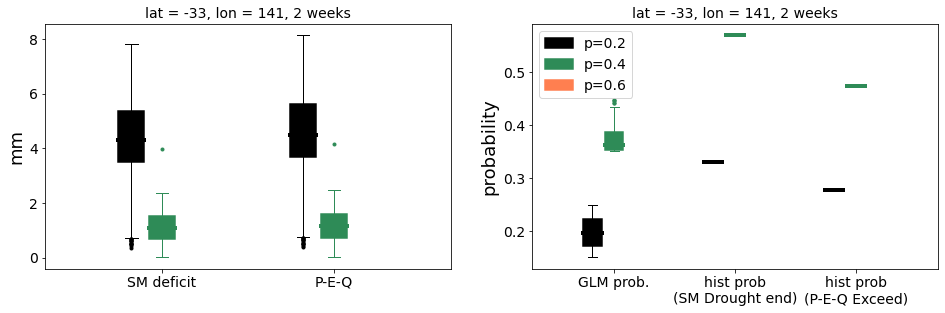

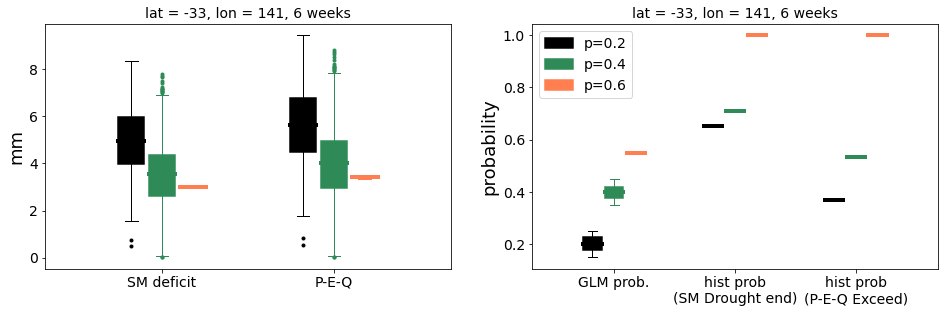

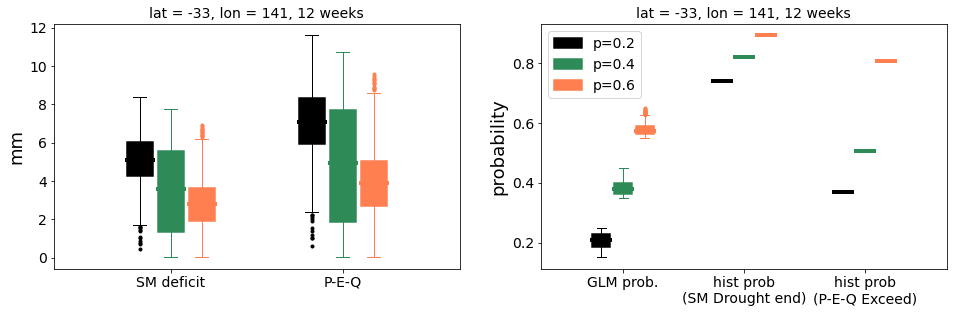

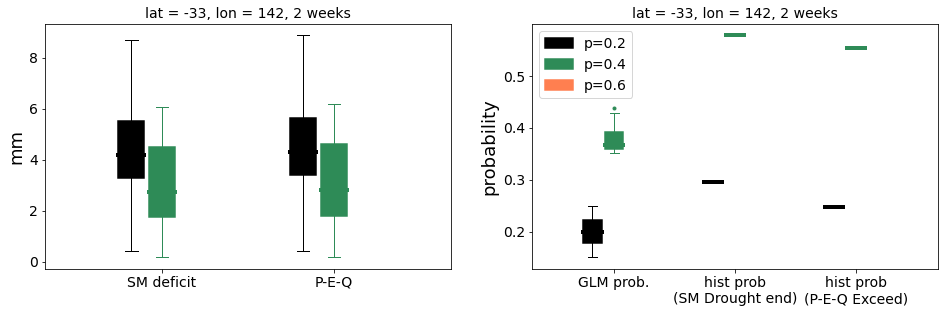

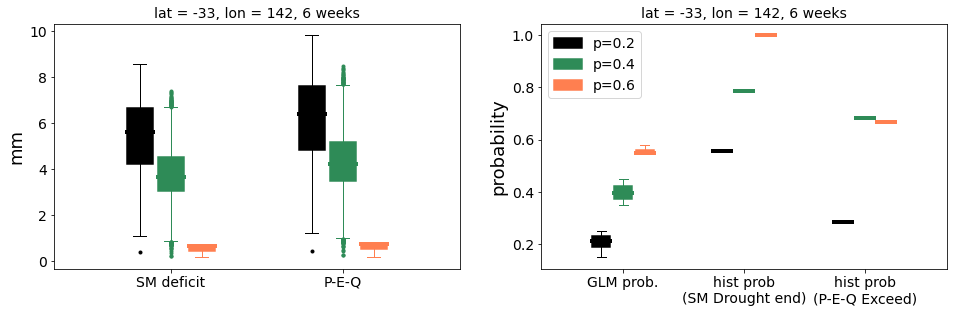

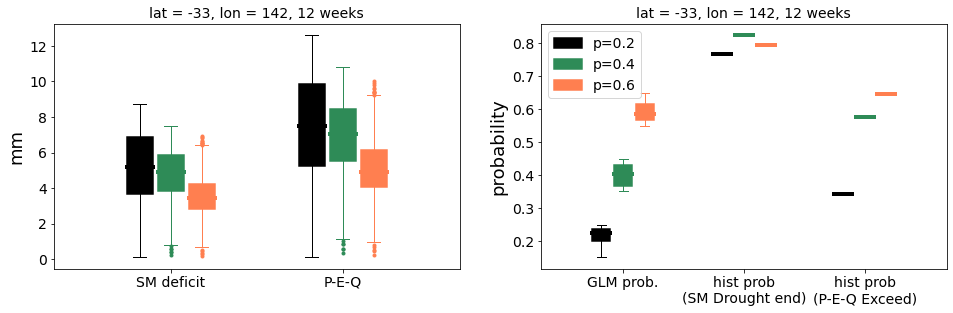

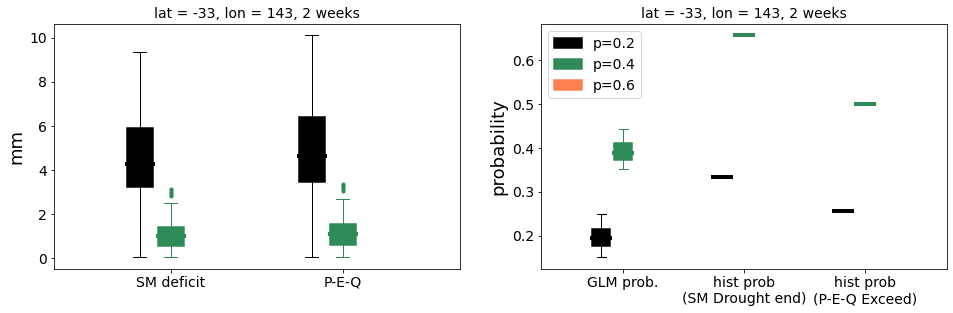

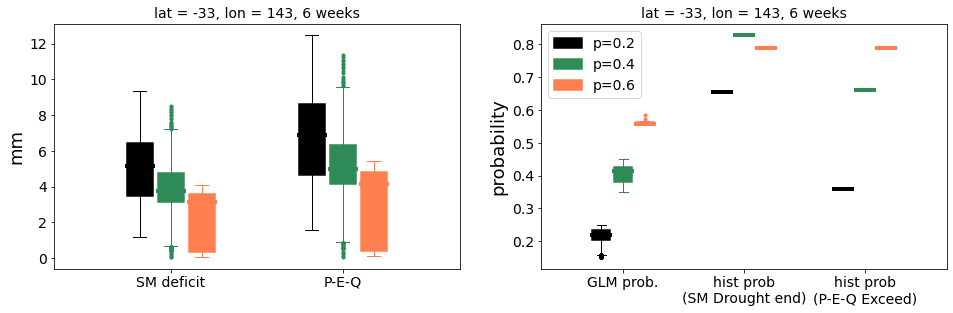

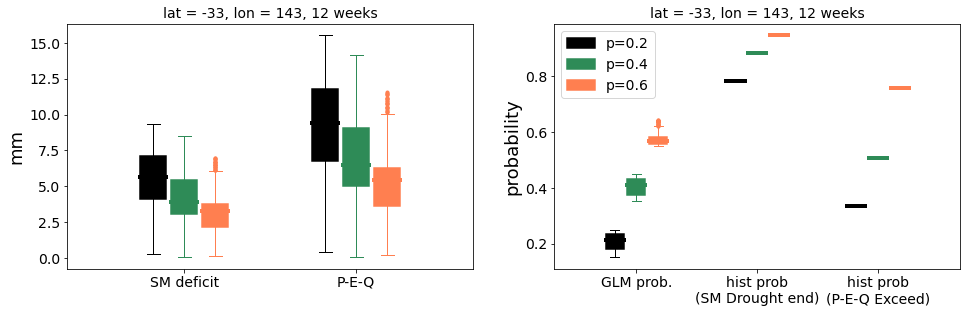

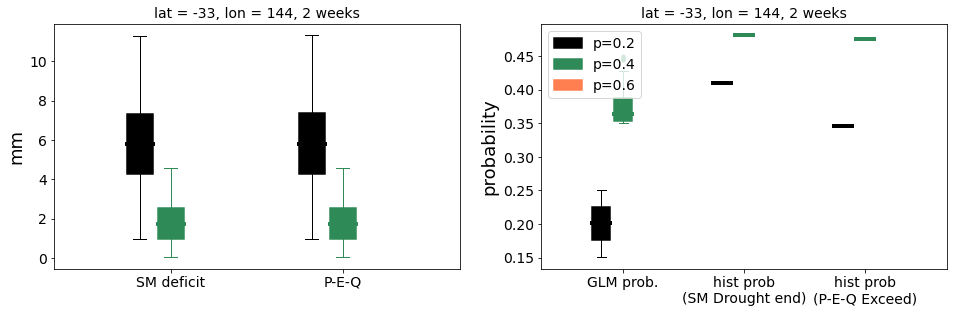

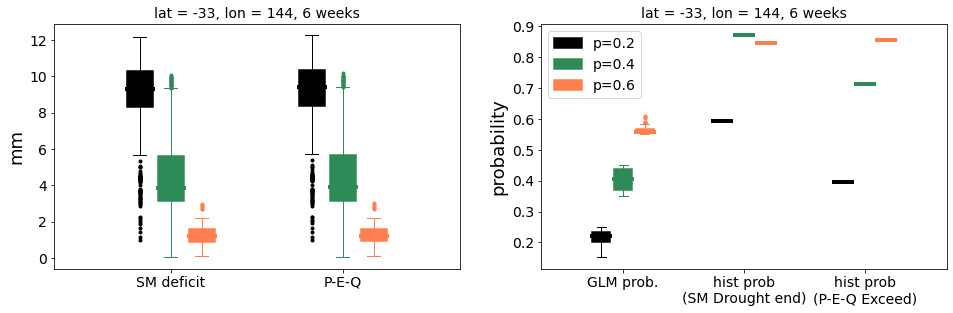

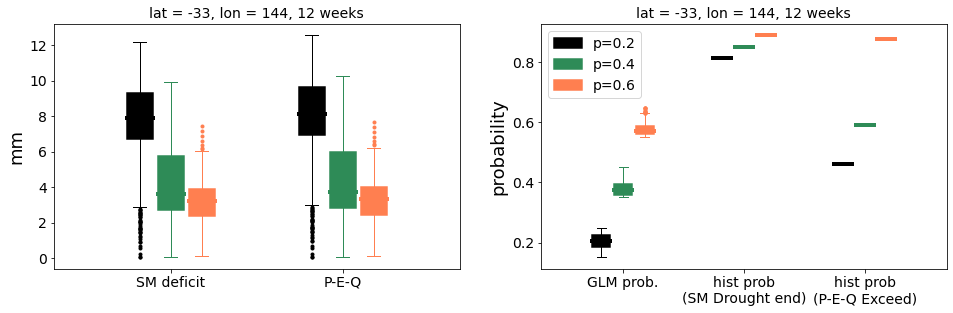

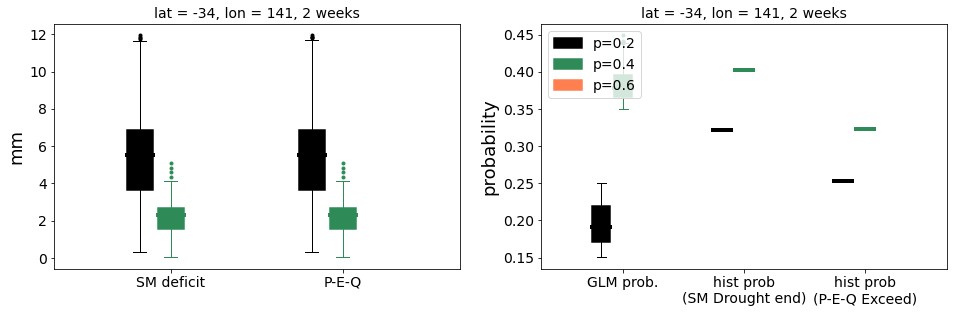

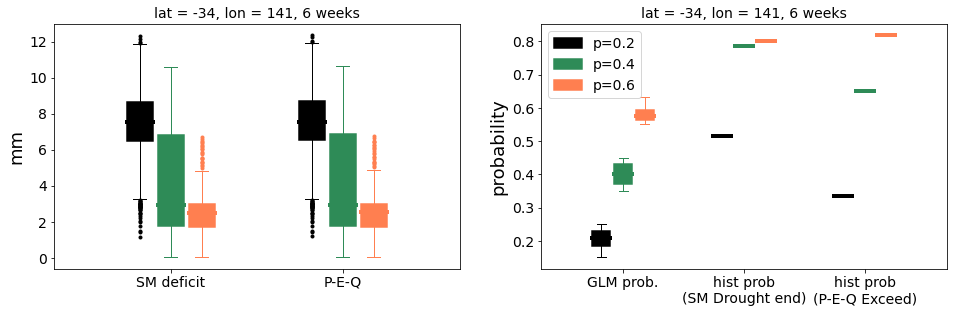

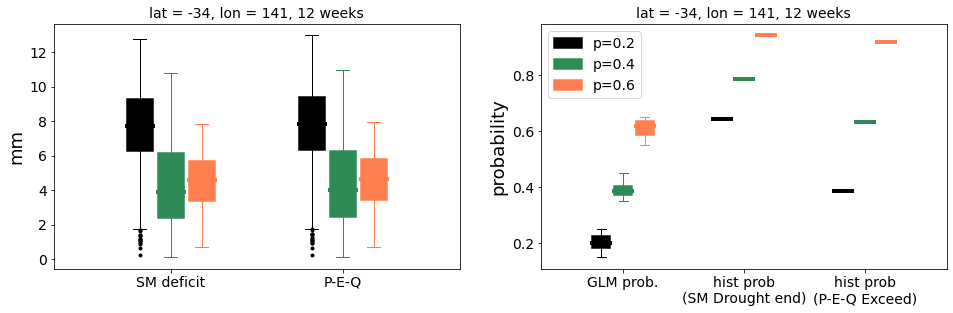

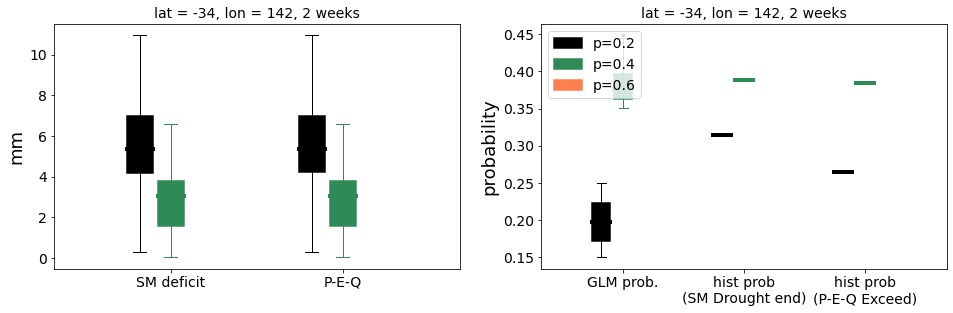

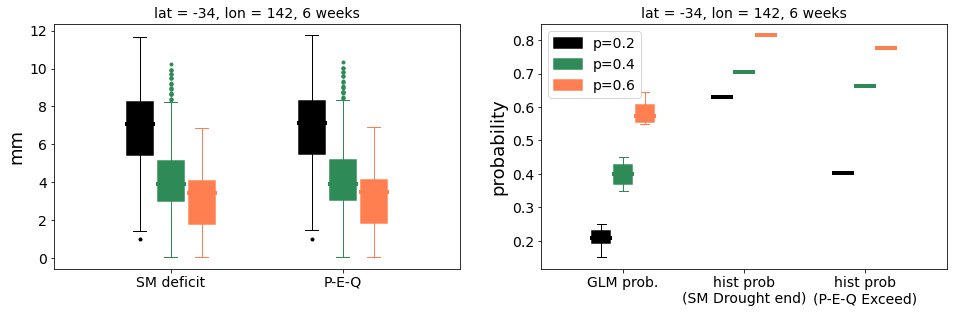

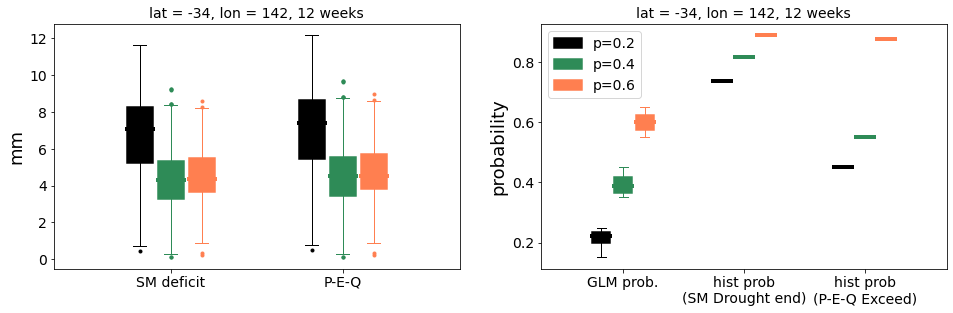

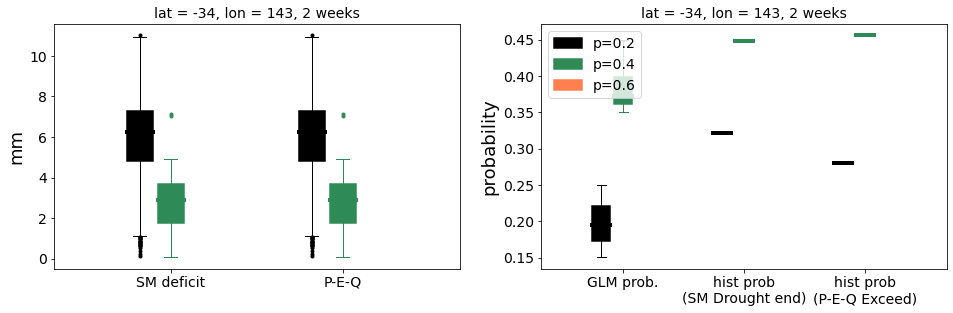

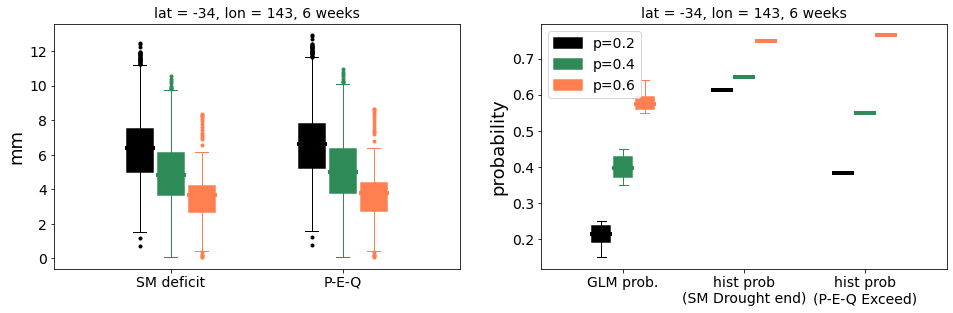

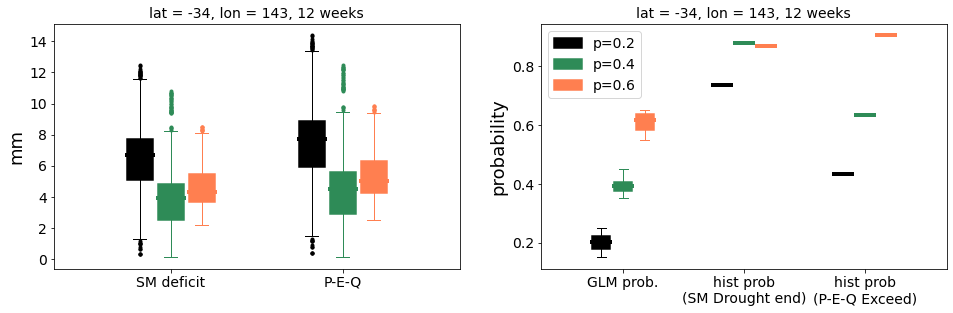

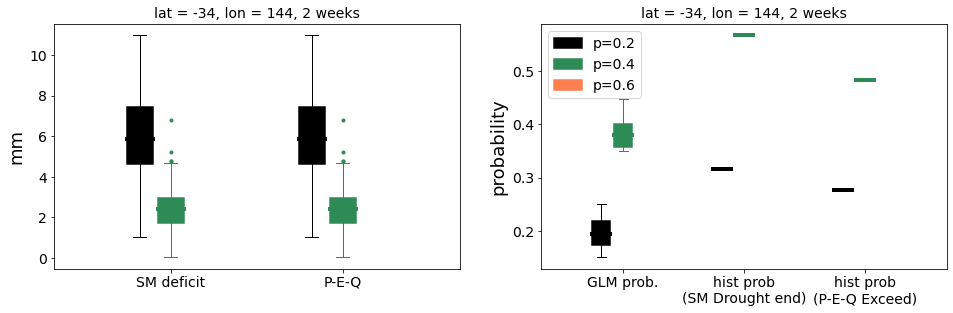

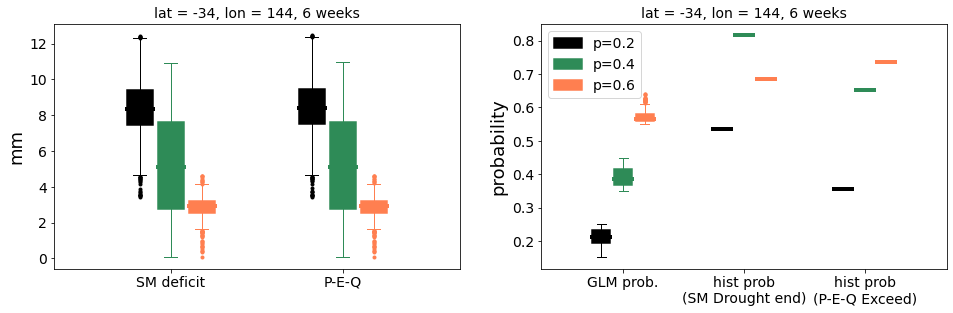

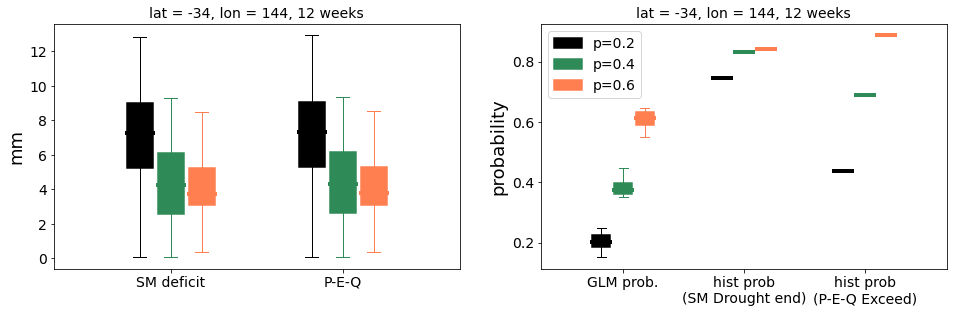

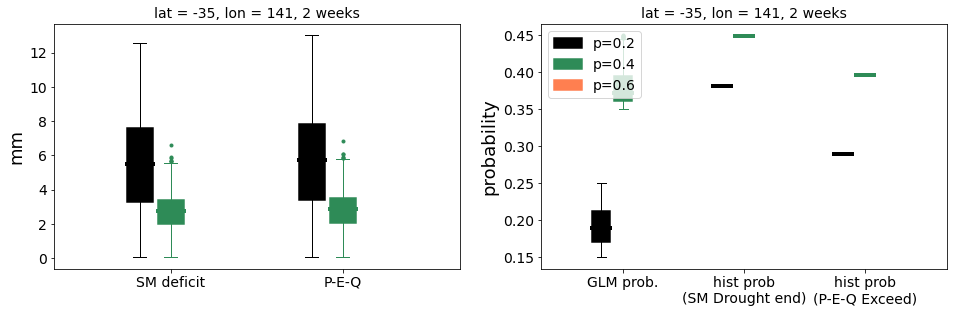

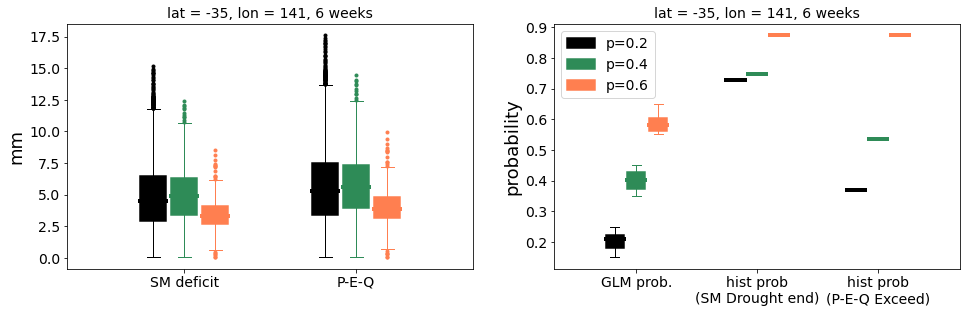

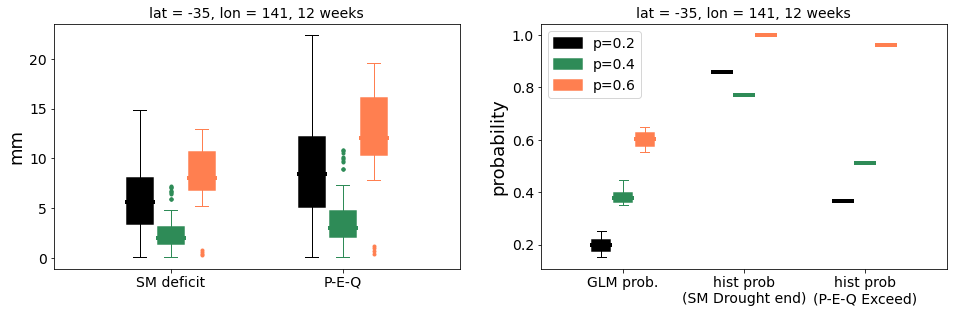

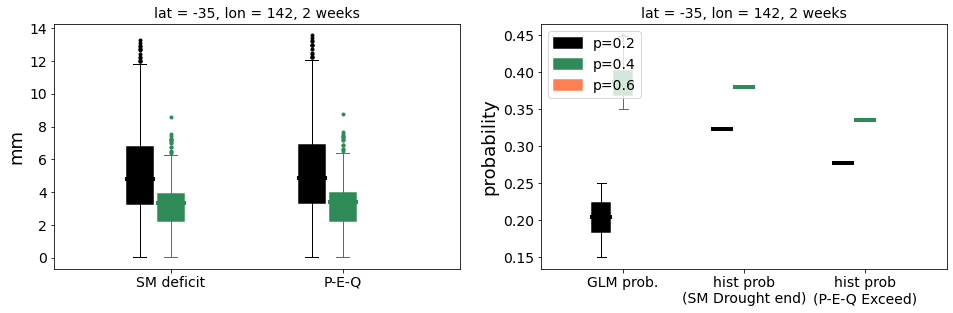

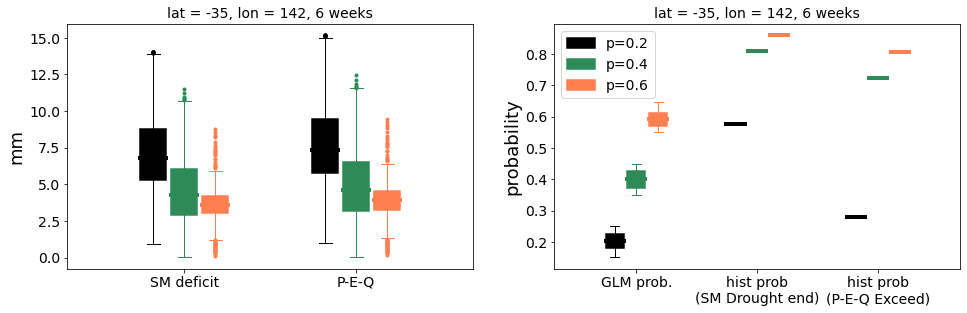

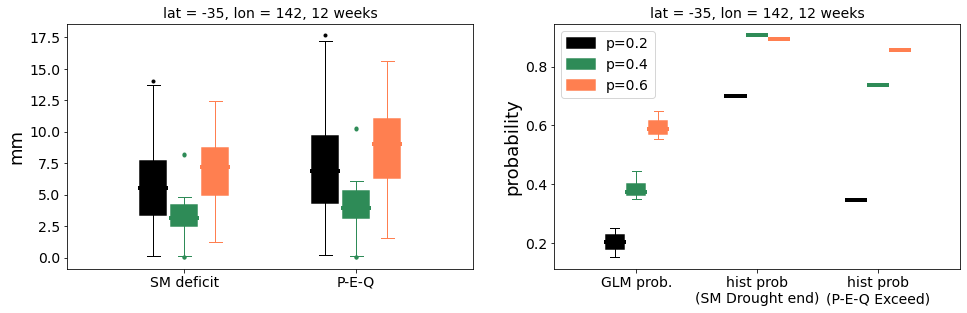

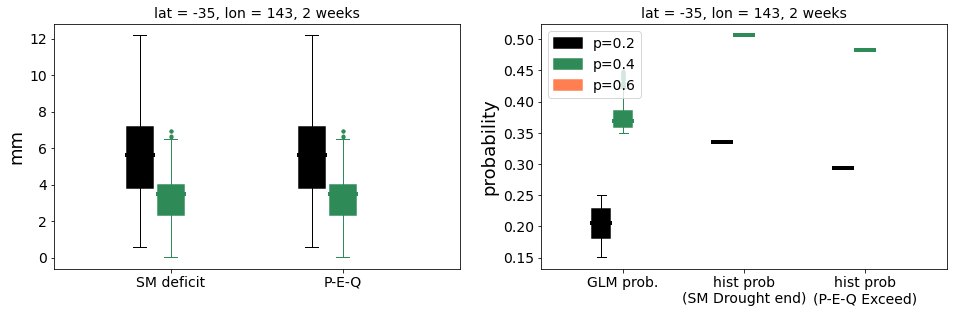

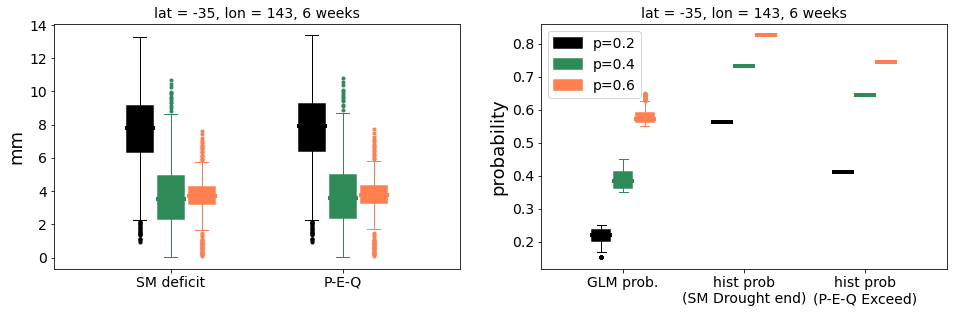

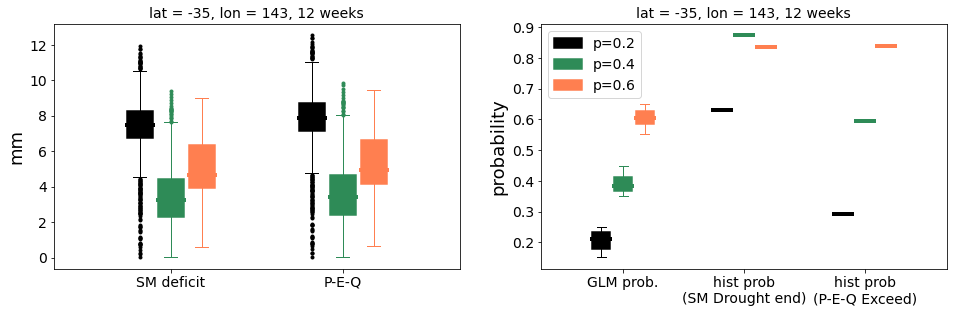

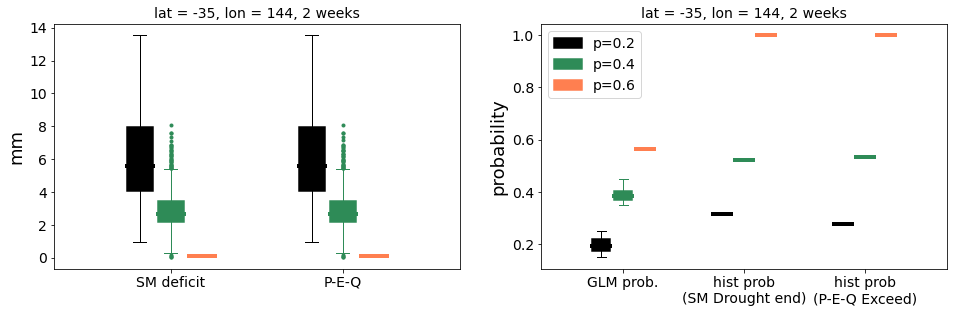

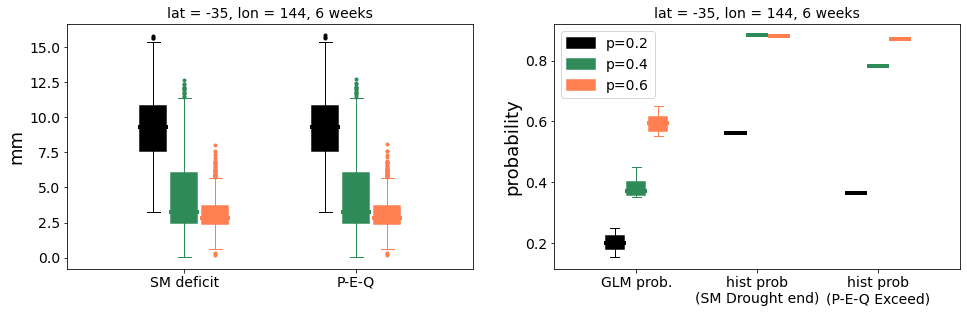

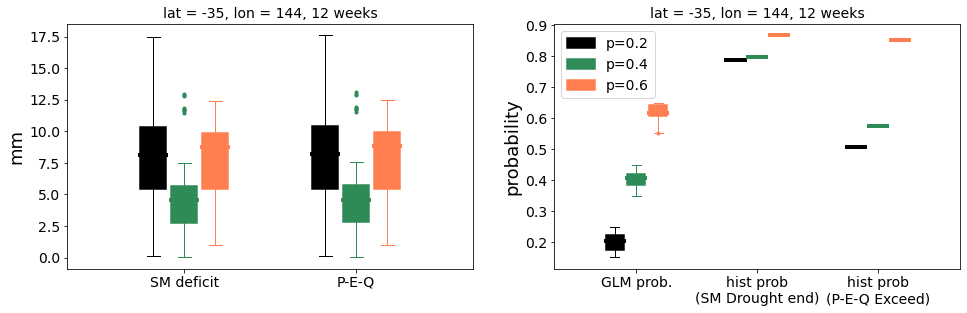

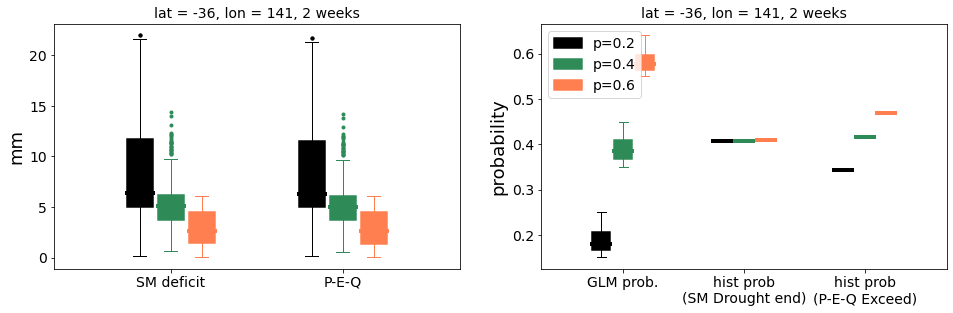

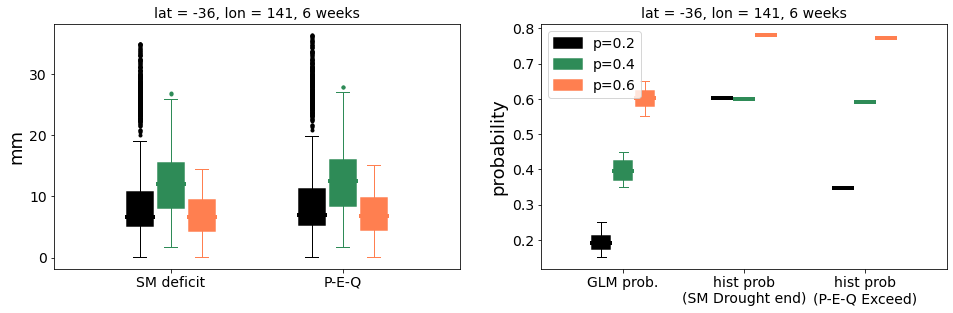

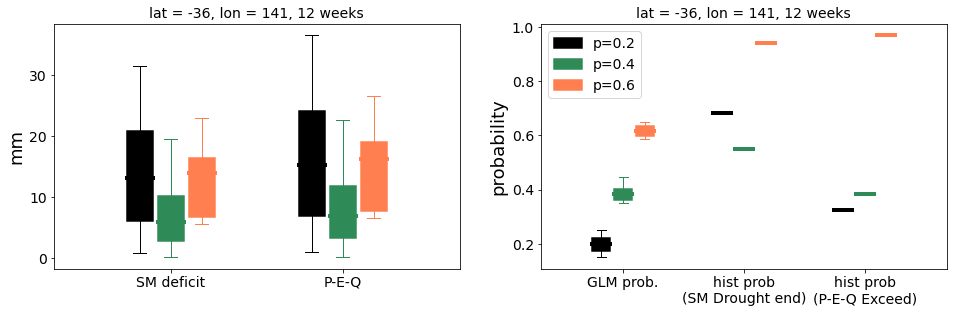

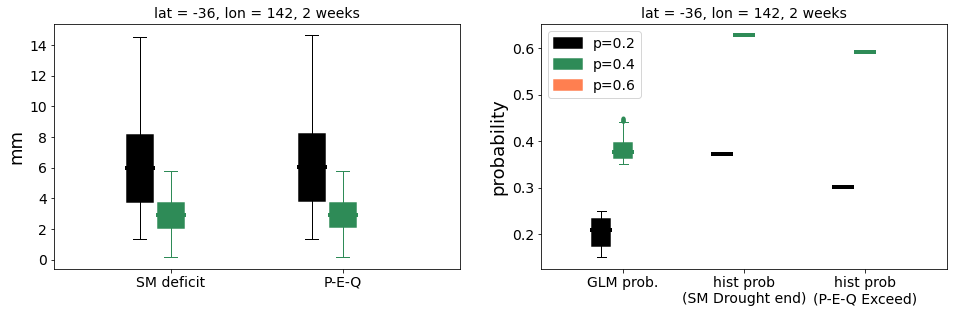

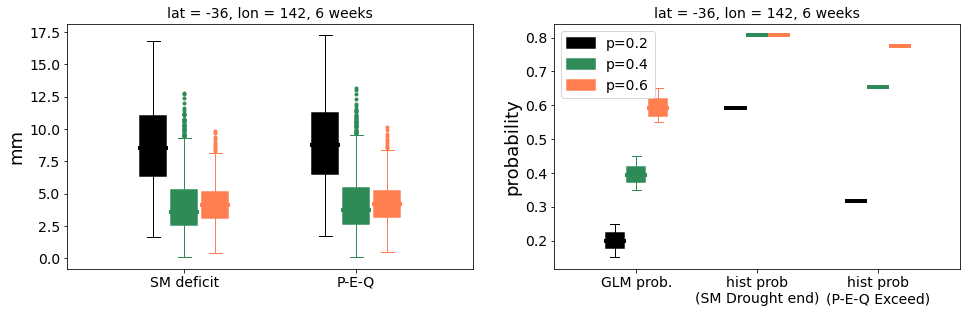

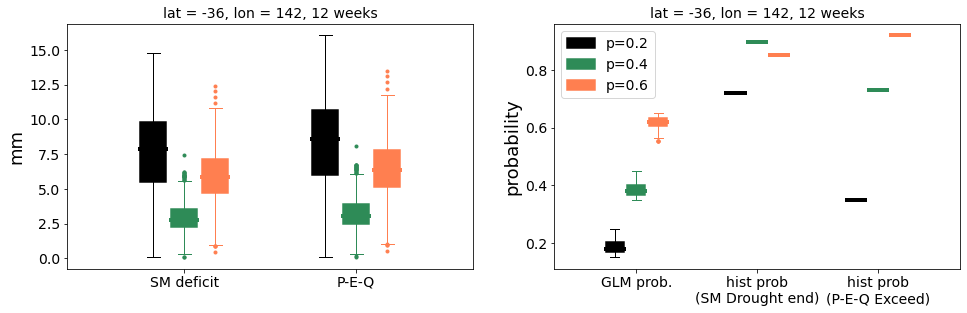

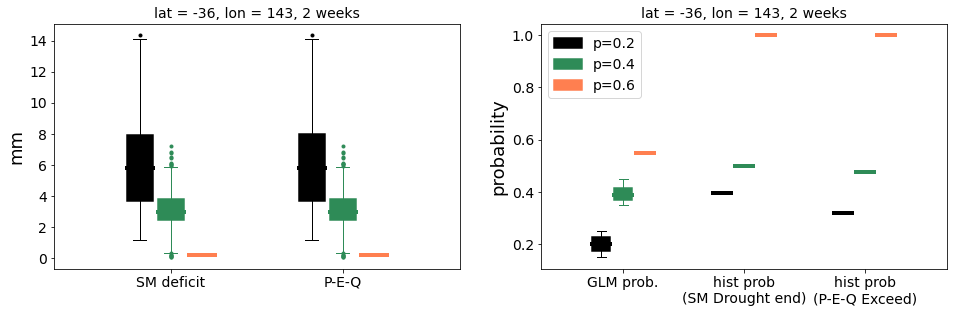

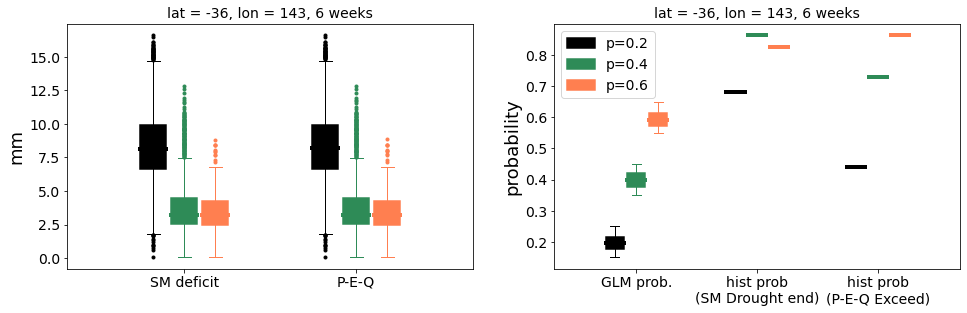

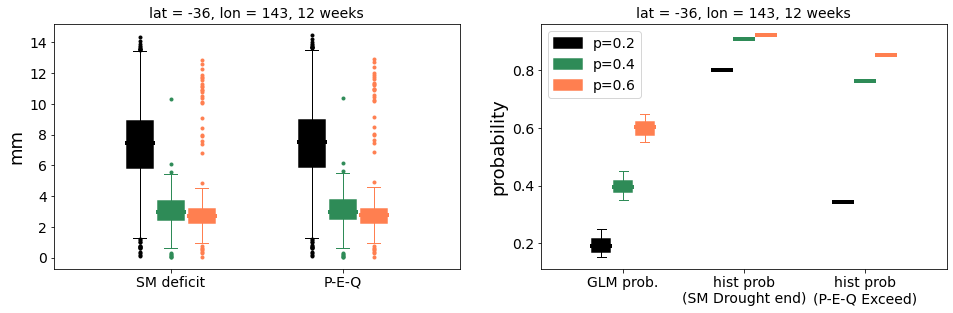

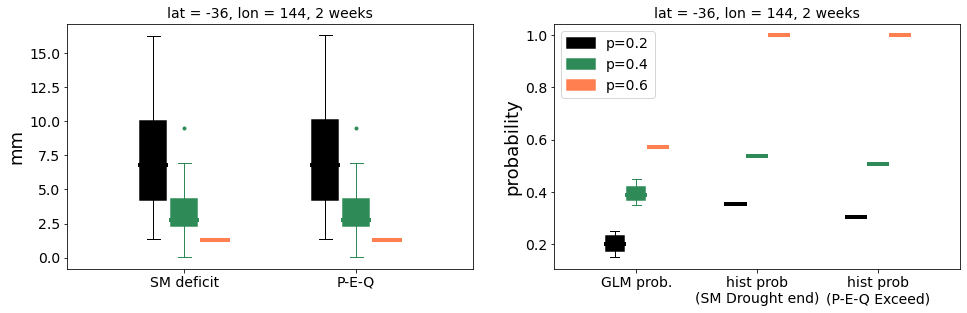

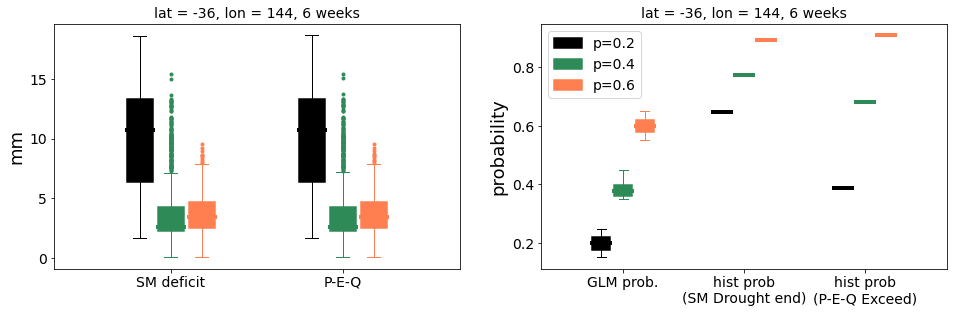

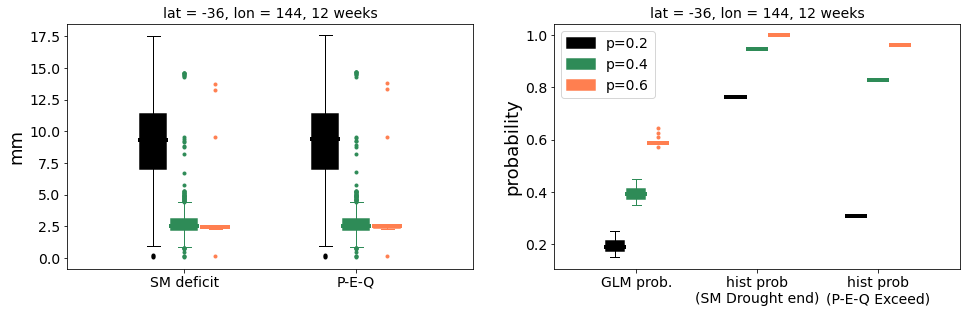

In [28]:
# box-plots: GLM probability full data, the mean GLM probability, historical drought-break probability, historical exceedence probability, SM deficit & desired P-E-Q accumulation

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

outdir = 'figures/SM_PmEQ_diagnosis/'
main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'
drght_dir = main_dir + 'GLM_results_full_record/validation/'
drght_time_slice = slice('1911-01-01', '2020-05-31')

band_no_list = [1, 3, 5]#, 7]
ts_list = [2, 6, 12]
lat_pt = -33
lon_pt = 147

band_name = np.linspace(0.1, 0.9, 9).round(2)
ds_sm_deficit = xr.open_mfdataset(main_dir + 'sm_droughts/sm_events_*.nc')
ds_PmEQ_thresh = xr.open_mfdataset(main_dir + 'sm_droughts/PmEQ_events_*.nc')

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth = 1.5)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color, linewidth = 4)
    plt.setp(bp['fliers'], color=color, markerfacecolor=color, markeredgecolor=None)
    
lat_pt_list = [-33, -33, -33, -33, 
               -34, -34, -34, -34,
               -35, -35, -35, -35,
               -36, -36, -36, -36]
lon_pt_list = [141, 142, 143, 144,
               141, 142, 143, 144,
               141, 142, 143, 144,
               141, 142, 143, 144]

for ipt in range(len(lat_pt_list)):
    lat_pt = lat_pt_list[ipt]
    lon_pt = lon_pt_list[ipt]
    for ts in ts_list:
        figname = 'boxplot_lat' + str(lat_pt) + '_lon' + str(lon_pt) + '_deficits_and_prob_' + str(ts) + '_weeks.png'
        
        data_y1_allbands = []
        data_y2_allbands = []
        for band_no in band_no_list:
            ds_glm_prob = xr.open_dataset(drght_dir + 'PmEQ_results/glm_probability_prob_band' + str(band_name[band_no]) + '_weeks' + str(ts) + '.nc')
            ds_hist_smDrght_break = xr.open_dataset(drght_dir + 'hist_prob_drought_break_band' + str(band_name[band_no]) + '.nc')
            ds_hist_PmEQ_exceed = xr.open_dataset(drght_dir + 'PmEQ_results/hist_prob_drought_break_band' + str(band_name[band_no]) + '_weeks' + str(ts) + '.nc')

            glm_prob = ds_glm_prob['glm_probability'].sel(lat = lat_pt, lon = lon_pt, time = drght_time_slice)
            hist_prob_smDrght_break = ds_hist_smDrght_break['hist_prob'].sel(timescale = ts, lat = lat_pt, lon = lon_pt)
            hist_prob_PmEQ_exceed = ds_hist_PmEQ_exceed['hist_prob'].sel(lat = lat_pt, lon = lon_pt)

            # get sm deficit & P-E-Q on the days in the probability band
            sm_deficit = ds_sm_deficit['sm_deficit'].sel(lat = lat_pt, lon = lon_pt, time = drght_time_slice).where(glm_prob>0)
            PmEQ_thresh = ds_PmEQ_thresh['PminusEQ'].sel(lat = lat_pt, lon = lon_pt, time = drght_time_slice, timescale = ts).where(glm_prob>0)

            data_y1 = [x[~np.isnan(x)] for x in [sm_deficit.values.flatten(), PmEQ_thresh.values.flatten()]]
            data_y2 = [x[~np.isnan(x)] for x in [glm_prob.values.flatten(), hist_prob_smDrght_break.values.flatten(), hist_prob_PmEQ_exceed.values.flatten()]]
            data_y1_allbands.append(data_y1)
            data_y2_allbands.append(data_y2)

        fig, axs = plt.subplots(1,2, figsize=(16, 4.5))
        titleText = 'lat = ' + str(lat_pt) + ', lon = ' + str(lon_pt) + ', ' + str(ts) + ' weeks'
        colors = ['black', 'seagreen', 'coral']
        groups = ['p=0.2', 'p=0.4', 'p=0.6']
        linsts = ['-', '-', '-', '-']

        tick_locs_x1 = np.arange(2)
        tick_locs_x2 = np.arange(3)

        # locations of the box plots
        x1 = tick_locs_x1 - 0.18
        x2 = tick_locs_x1
        x3 = tick_locs_x1 + 0.18
        data_x1_allbands = [x1, x2, x3]
        x1 = tick_locs_x2 - 0.18
        x2 = tick_locs_x2
        x3 = tick_locs_x2 + 0.18
        data_x2_allbands = [x1, x2, x3]

        # locations correspond to the thresholds used for calc. of exceedence probabilities
        median_color = "black"
        tick_labels_x1 = ['SM deficit', 'P-E-Q']
        tick_labels_x2 = [r"GLM prob.", r"hist prob""\n"r"(SM Drought end)", r"hist prob""\n"r"(P-E-Q Exceed)"]

        bp_leg0 = []
        for x, y, color, group in zip(data_x1_allbands, data_y1_allbands, colors, groups):
            bp = axs[0].boxplot(y, positions=x, sym='.', widths=0.15, patch_artist=True) #, notch = True)
            set_box_color(bp, color)
            bp_leg0.append(bp["boxes"][0])         
        axs[0].set(title = titleText)
        axs[0].set_ylabel('mm')
        axs[0].set_xticks(tick_locs_x1) 
        axs[0].set_xticklabels(tick_labels_x1)

        bp_leg1 = []
        for x, y, color, group in zip(data_x2_allbands, data_y2_allbands, colors, groups):
            bp = axs[1].boxplot(y, positions=x, sym='.', widths=0.15, patch_artist=True) #, notch = True)
            set_box_color(bp, color)
            bp_leg1.append(bp["boxes"][0])        
        axs[1].set(title = titleText)
        axs[1].set_ylabel('probability')
        axs[1].set_xticks(tick_locs_x2) 
        axs[1].set_xticklabels(tick_labels_x2) 
        axs[1].legend(bp_leg1, groups, loc='upper left')

        plt.savefig(outdir+figname)

In [20]:
len(data_x2_allbands[0])

2

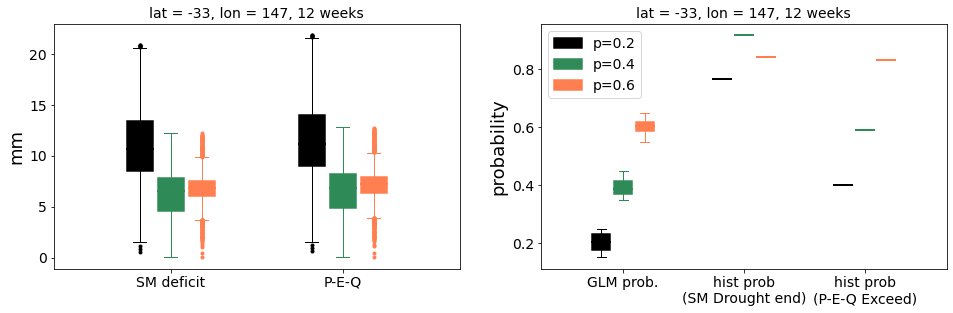

In [27]:
fig, axs = plt.subplots(1,2, figsize=(16, 4.5))
titleText = 'lat = ' + str(lat_pt) + ', lon = ' + str(lon_pt) + ', ' + str(ts) + ' weeks'

colors = ['black', 'seagreen', 'coral']
groups = ['p=0.2', 'p=0.4', 'p=0.6']
linsts = ['-', '-', '-', '-']

tick_locs_x1 = np.arange(2)
tick_locs_x2 = np.arange(3)

# locations of the box plots
x1 = tick_locs_x1 - 0.18
x2 = tick_locs_x1
x3 = tick_locs_x1 + 0.18
data_x1_allbands = [x1, x2, x3]
x1 = tick_locs_x2 - 0.18
x2 = tick_locs_x2
x3 = tick_locs_x2 + 0.18
data_x2_allbands = [x1, x2, x3]

# locations correspond to the thresholds used for calc. of exceedence probabilities
median_color = "black"
tick_labels_x1 = ['SM deficit', 'P-E-Q']
tick_labels_x2 = [r"GLM prob.", r"hist prob""\n"r"(SM Drought end)", r"hist prob""\n"r"(P-E-Q Exceed)"]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth = 1.5)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color, linewidth = 4)
    plt.setp(bp['fliers'], color=color, markerfacecolor=color, markeredgecolor=None)

bp_leg0 = []
for x, y, color, group in zip(data_x1_allbands, data_y1_allbands, colors, groups):
    bp = axs[0].boxplot(y, positions=x, sym='.', widths=0.15, patch_artist=True) #, notch = True)
    set_box_color(bp, color)
    bp_leg0.append(bp["boxes"][0])         

axs[0].set(title = titleText)
axs[0].set_ylabel('mm')
axs[0].set_xticks(tick_locs_x1) 
axs[0].set_xticklabels(tick_labels_x1)

bp_leg1 = []
for x, y, color, group in zip(data_x2_allbands, data_y2_allbands, colors, groups):
    bp = axs[1].boxplot(y, positions=x, sym='.', widths=0.15, patch_artist=True) #, notch = True)
    set_box_color(bp, color)
    bp_leg1.append(bp["boxes"][0])        

axs[1].set(title = titleText)
axs[1].set_ylabel('probability')
axs[1].set_xticks(tick_locs_x2) 
axs[1].set_xticklabels(tick_labels_x2) 
axs[1].legend(bp_leg1, groups, loc='upper left')

plt.savefig(outdir+figname)

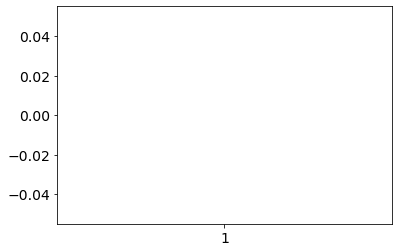

In [112]:
plt.boxplot([data_y1[0]])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7ed1a5a5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7ed1a5a340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7ed1ebb1c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7ed1e662e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7ed1e663a0>],
 'means': []}

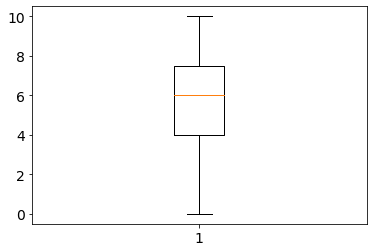

In [113]:
plt.boxplot([0, 5, 7, 6, 3, 10, 8])

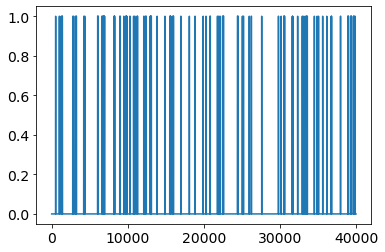

In [115]:
plt.plot(data_y1[0])

In [95]:
sm_def = ds_sm_deficit['sm_deficit'].sel(lat = lat_pt, lon = lon_pt, time = drght_time_slice).load()

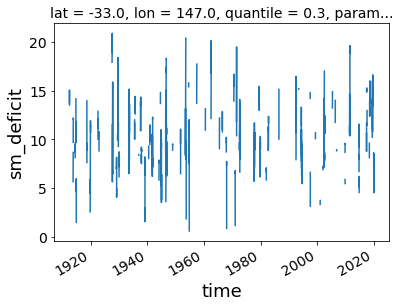

In [101]:
sm_def.where(glm_prob>0).plot()

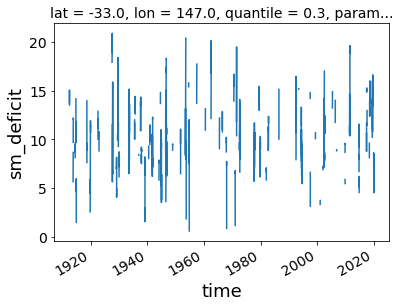

In [102]:
ds_sm_deficit['sm_deficit'].sel(lat = lat_pt, lon = lon_pt, time = drght_time_slice).where(glm_prob>0).plot()

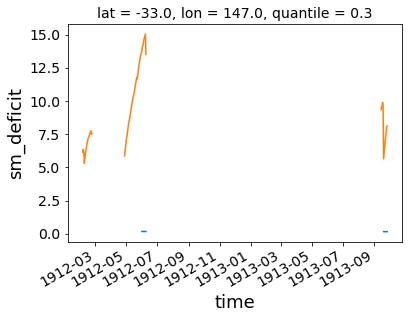

In [99]:
glm_prob[0:1000].plot()
sm_def[0:1000].plot()

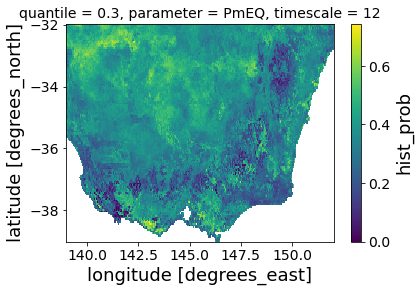

In [74]:
ds_hist2['hist_prob'].plot()

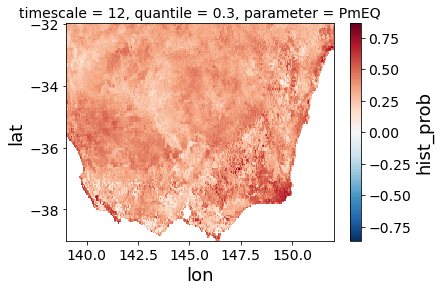

In [77]:
(ds_hist1['hist_prob'].sel(timescale = 12)-ds_hist2['hist_prob']).plot()

In [ ]:
%who